# 02 FFT Feature Extraction


**Objective:**
Extract frequency-domain features from resampled 100ms OHLCV bars using sliding windows and FFT.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_ingestion.fetch_binance_data import fetch_historical_agg_trades
from preprocessing.resample_ticks import resample_tick_data
from feature_extraction.windowing import sliding_window
from feature_extraction.fft_features import compute_fft_features
from utils.config import DATA_DIR, DEFAULT_FREQ, DEFAULT_WINDOW_SIZE, DEFAULT_N_FFT_FEATURES, DEFAULT_FETCH_WINDOW_MINUTES
from utils.plotting import plot_fft_spectrum

In [2]:
# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

## 1. Fetch Historical Aggregated Trade Data

Fetch 10 minutes of aggregated trades for XRP/USDT using Binance's public `/aggTrades` endpoint.

In [3]:
end_ts = int(pd.Timestamp.utcnow().timestamp() * 1000)
start_ts = end_ts - DEFAULT_FETCH_WINDOW_MINUTES * 60 * 1000

# Fetch aggregated trades
df_ticks = fetch_historical_agg_trades(
    symbol="XRPUSDT",
    start_time=start_ts,
    end_time=end_ts,
    limit=1000
)

# Preview the tick data
df_ticks.head()

,price,volume
timestamp,,
2025-05-14 23:58:15.597,2.5518,5.0
2025-05-14 23:58:15.664,2.5519,73.0
2025-05-14 23:58:19.381,2.5519,21.5
2025-05-14 23:58:21.150,2.5518,4.5
2025-05-14 23:58:21.617,2.5518,164.0


## 2. Resample to 100ms OHLCV Bars

Convert irregular tick data into uniform 100ms bars (OHLCV).

In [4]:
bars = resample_tick_data(df_ticks, freq=DEFAULT_FREQ)
bars.head()

,open,high,low,close,volume
timestamp,,,,,
2025-05-14 23:58:15.500,2.5518,2.5518,2.5518,2.5518,5.0
2025-05-14 23:58:15.600,2.5519,2.5519,2.5519,2.5519,73.0
2025-05-14 23:58:15.700,2.5519,2.5519,2.5519,2.5519,0.0
2025-05-14 23:58:15.800,2.5519,2.5519,2.5519,2.5519,0.0
2025-05-14 23:58:15.900,2.5519,2.5519,2.5519,2.5519,0.0


## 3. Generate Sliding Windows

Create non-overlapping windows of size `DEFAULT_WINDOW_SIZE` from the resampled bars.

In [5]:
windows = list(sliding_window(
    df=bars,
    window_size=DEFAULT_WINDOW_SIZE,
    step_size=DEFAULT_WINDOW_SIZE
))
print(f"Total windows obtained: {len(windows)}")

# Validate window count
if len(windows) == 0:
    raise ValueError(
        f"Resampled data length ({len(bars)}) is smaller than window size ({DEFAULT_WINDOW_SIZE}). "
        "Consider increasing the fetch window or decreasing `DEFAULT_WINDOW_SIZE` in utils.config."
    )

Total windows obtained: 140


## 4. Compute FFT Features

For each window, compute the top `DEFAULT_N_FFT_FEATURES` frequency components and their magnitudes.

In [6]:
# Calculate sampling rate from the resample frequency
dt = pd.to_timedelta(DEFAULT_FREQ).total_seconds()
sample_rate = 1.0 / dt

# Extract FFT features for each window
features = []
for idx, window_df in windows:
    feats = compute_fft_features(
        series=window_df['close'],
        n_features=DEFAULT_N_FFT_FEATURES,
        sample_rate=sample_rate
    )
    features.append(feats)

# Stack feature vectors into a matrix
X_fft = np.vstack(features)
print("Feature matrix shape:", X_fft.shape)

Feature matrix shape: (140, 20)


## 5. Visualize FFT Spectrum of the First Window

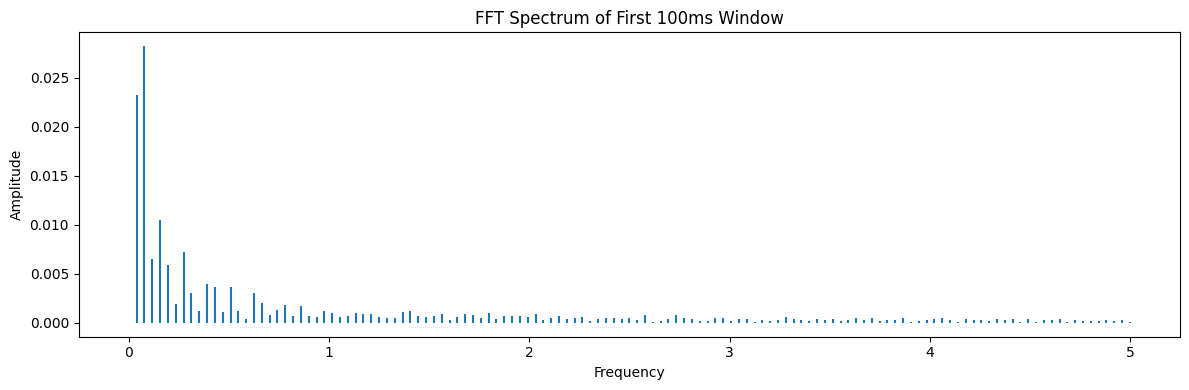

In [7]:
plot_fft_spectrum(
    series=windows[0][1]['close'],
    sample_rate=sample_rate,
    title='FFT Spectrum of First 100ms Window'
)

## 6. Save FFT Feature Matrix

Save the feature matrix `X_fft` to disk for downstream modeling.

In [8]:
output_path = os.path.join(DATA_DIR, 'X_fft.npy')
np.save(output_path, X_fft)
print(f"Saved FFT feature matrix to {output_path}")

Saved FFT feature matrix to /Users/yechanjeong/Desktop/computational_python/FFT_Project/Crypto_FFT_ML_Analysis/data/X_fft.npy


**Next:** Proceed to `03_ml_modeling.ipynb` to load `X_fft.npy`, generate labels, and train classification and regression models.